In [1]:
%pylab
%matplotlib inline
rc('text', usetex = False)
import pandas as pd
import cosmoslik as cs
from cosmoslik_plugins.samplers.metropolis_hastings import load_chain
from scipy.stats import norm, chi2
import pickle

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
def like1d(data, weights, bins = 100):
    
    H, xe = histogram(data,bins,weights=weights,normed=False)
    xem = movavg(xe,2)
    fitdata = [[d]*w for d,w in zip(data, weights)]
    fitdata = [item for sublist in fitdata for item in sublist]
    mu, sigma = norm.fit(fitdata)
    maxval = max(norm.pdf(linspace(min(data), max(data), 10000), scale = sigma, loc = mu))
    return H, xem, mu, sigma, maxval

In [3]:
def likelihood(data, weights, bins = 100):
    
    H, xe = histogram(data,bins,weights=weights,normed=False)
    xem = movavg(xe,2)
    fitdata = [[d]*w for d,w in zip(data, weights)]
    fitdata = [item for sublist in fitdata for item in sublist]
    df, mu, sigma = chi2.fit(fitdata)
    maxval = max(chi2.pdf(df, linspace(min(data), max(data), 10000), scale = sigma, loc = mu))
    return H,  df, xem, mu, sigma, maxval

In [4]:
    def get_data():
        '''
        Grabs the cepheids and sne from the R16 sample
        returns: 
            cepheids: Cepheid dataframe
            sne: sne dataframe
        '''
        filename = '../data/r16_table4.out'
        sne_start = 40
        sne_end = 59
        sne_lines = arange(sne_start,sne_end)
        sne = pd.DataFrame(columns = ['Host', 'sne', 'm^B_0', 'err'], index = arange(sne_end - sne_start))
        ceph_start = 70
        ceph_end = 2346
        cepheid_lines = arange(ceph_start,ceph_end)
        cepheids = pd.DataFrame(columns = ['Field','RA','DEC','ID','Period','VminusI','m_H','sigma_tot','Z'], 
                                index = arange(ceph_end - ceph_start),
                               dtype = 'float')
        f = file(filename)
        for i, line in enumerate(f):
            if i in sne_lines:
                sne.loc[i-sne_start] = line.lower().split()
            if i in cepheid_lines:
                cepheids.loc[i-ceph_start] = line.lower().split()

        f.close()
        cepheids = cepheids.apply(lambda x: pd.to_numeric(x, errors='ignore') );

        sne = sne.apply(lambda x: pd.to_numeric(x, errors='ignore') );
        
        
        parallaxes = {'bgcru': (2.23, 0.30,-0.15), 
                      'dtcyg':(2.19,0.33, -0.18), 
                      'ffaql':(2.64,0.16, -0.03),
                      'rtaur':(2.31, 0.19,-0.06),
                      'sscma':(0.348, 0.038, -0.04),
                      'sucas':(2.57,  0.33, -0.13 ),
                      'syaur':(0.428, 0.054, -0.04),
                      'tvul':(2.06,0.22,-0.09 ),
                      'wsgr':(2.30, 0.19, -0.06),
                      'xsgr':(3.17, 0.14, -0.02),
                      'ysgr':(2.13, 0.29, -0.15),
                      'betador':(3.26, 0.14, -0.02),
                      'delceph':(3.71,0.12,-0.01),
                      'etagem':(2.74,0.12,-0.02),
                      'lcar':(2.03,0.16,-0.05)
                     }
        parallaxes = pd.DataFrame.from_dict(parallaxes, orient = 'index', )
        parallaxes.reset_index(inplace=True)
        parallaxes.columns = ['ID', 'parallax', 'p_err', 'LK']
        cepheids = cepheids.merge(parallaxes, on = 'ID', how = 'left')
        

        cepheids.fillna({'parallax':1e-03, 'p_err':0, 'LK':0}, inplace = True);
        cepheids['err'] = sqrt(cepheids.sigma_tot**2 + (cepheids.p_err / cepheids.parallax * 5/log(10))**2)
        return cepheids, sne

In [5]:
cepheids, sne = get_data()

In [6]:
burnins = 2500

In [7]:
base = load_chain('base_1pop.chain').burnin(burnins).join()

In [8]:
base.best_fit()['lnl']

1129.1685308693111

In [9]:
varyR = load_chain('varyR_prior_0.1.chain.2').burnin(burnins).join()


In [10]:
base_cut = load_chain('cut_extinction_break.chain').burnin(burnins).join()

In [11]:
varyR_cut = load_chain('cut_varyR_prior_0.1.chain').burnin(burnins).join()

In [12]:
cutoff = load_chain('cutoff.chain').burnin(burnins).join()

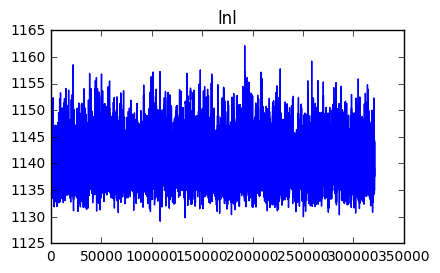

In [9]:
base.plot('lnl')
base.best_fit()['lnl']
base.savecov('proposal.covmat')

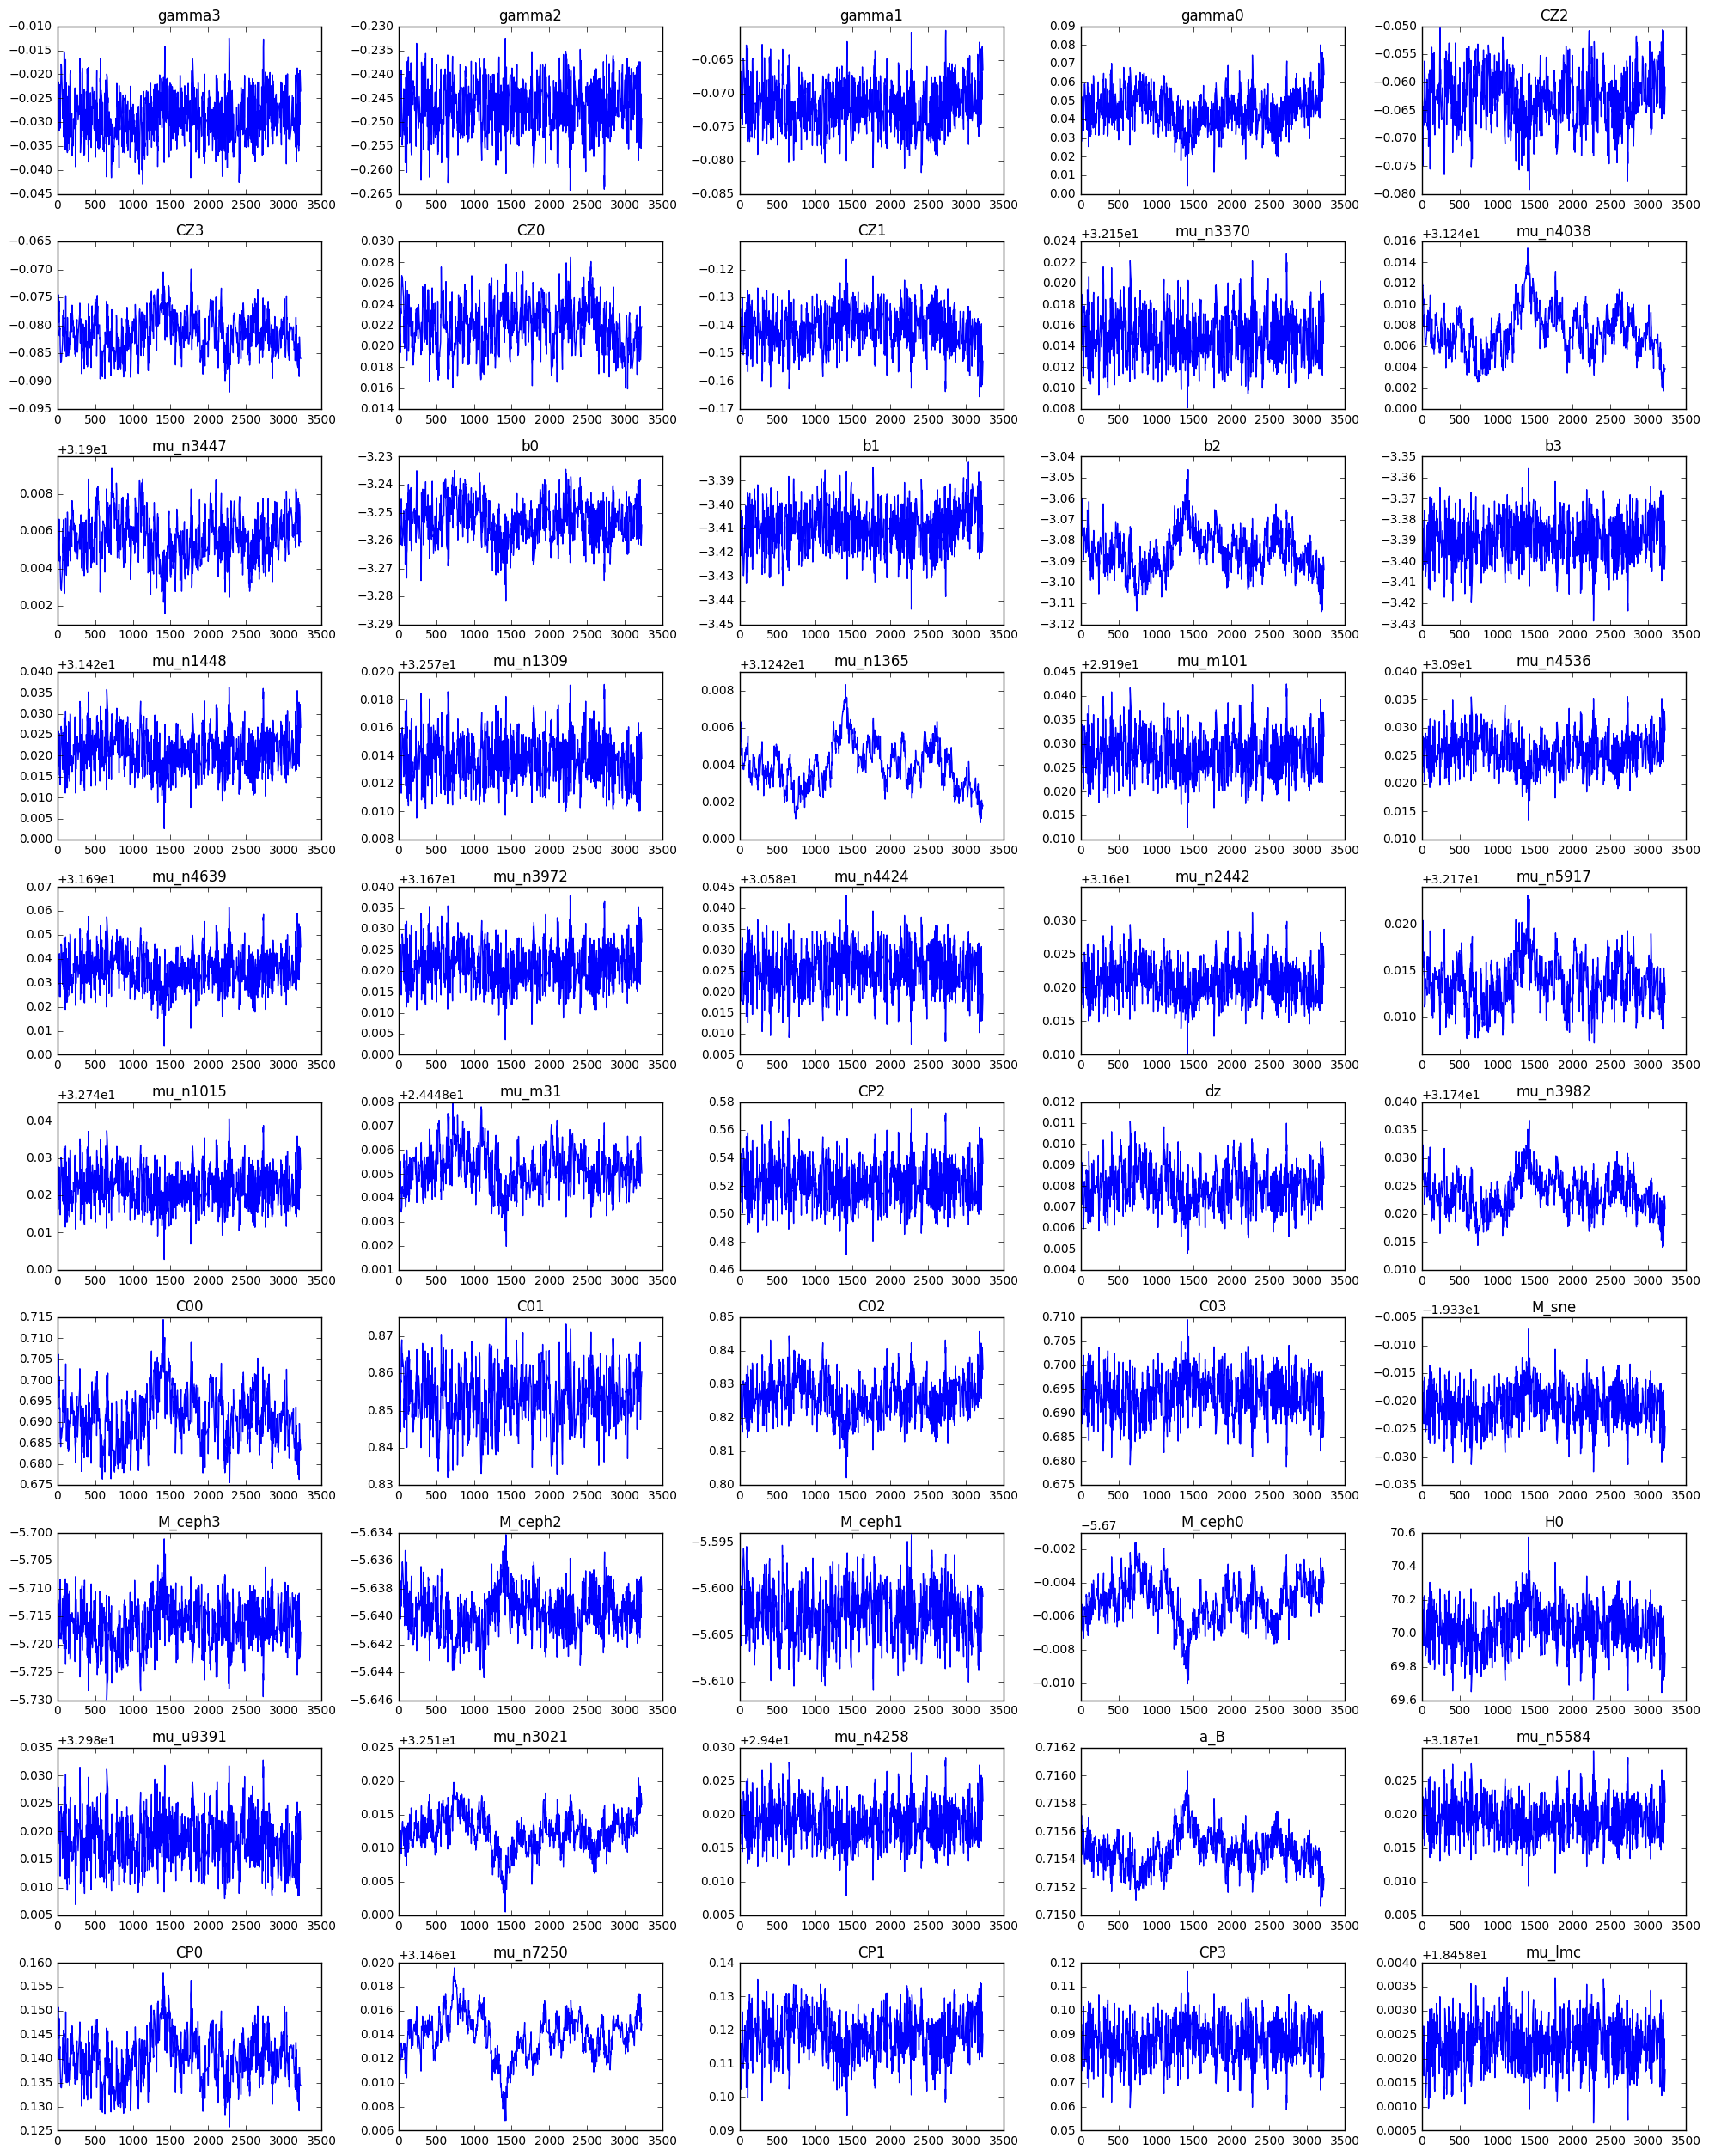

In [49]:
# base.savecov('multipops.covmat')
base.plot()

In [10]:
base.best_fit()

{'C00': 0.39471630148851833,
 'CP0': 0.21587813207935894,
 'CZ0': -0.24704168425581044,
 'H0': 73.812789010390432,
 'M_ceph0': -5.7852460863591109,
 'M_sne': -19.233661030935288,
 'a_B': 0.71486382160692796,
 'b0': -3.1574789348052761,
 'dz': 0.0015950490454337708,
 'gamma0': -0.25474252006719145,
 'lnl': 1129.1685308693111,
 'mu_lmc': 18.472230835274161,
 'mu_m101': 29.126731982368902,
 'mu_m31': 24.413775704613247,
 'mu_n1015': 32.556689248921629,
 'mu_n1309': 32.52526721688163,
 'mu_n1365': 31.293014886913419,
 'mu_n1448': 31.315053952159278,
 'mu_n2442': 31.503860449484822,
 'mu_n3021': 32.347768740027085,
 'mu_n3370': 32.050340298548491,
 'mu_n3447': 31.901528232553474,
 'mu_n3972': 31.604591937944242,
 'mu_n3982': 31.666247588168474,
 'mu_n4038': 31.3278085982801,
 'mu_n4258': 29.307867418356395,
 'mu_n4424': 30.864662986136825,
 'mu_n4536': 30.872347840077119,
 'mu_n4639': 31.577291787732179,
 'mu_n5584': 31.775424253711456,
 'mu_n5917': 32.217348822259979,
 'mu_n7250': 31.48148

# Plot of $H_0$

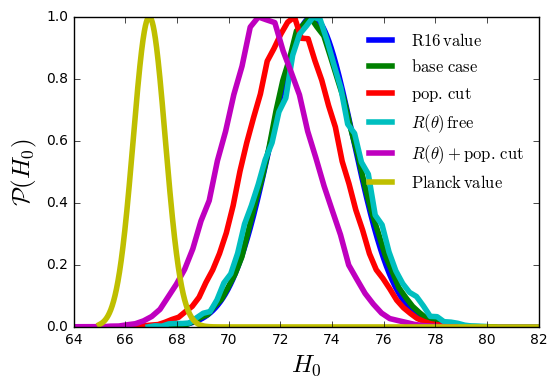

In [68]:
bins = linspace(65,85, 100)
x = linspace(65,82, 10000)
H0R16 = norm(scale = 1.59, loc = 73.24)
plot(x, H0R16.pdf(x)/max(H0R16.pdf(x)), label = r'${\rm R16 \, value}$', lw = 4)
## Base case
base.like1d('H0', label = r'${\rm base \, \, case}$', lw = 4, nbins = 50)
base_cut.like1d('H0', label = r'${\rm pop.\, cut}$', lw = 4, nbins = 50)


## varyR
varyR.like1d('H0', label = r'$R(\theta) {\rm \, free}$', lw = 4, nbins = 50)
varyR_cut.like1d('H0', label = r'$R(\theta) + {\rm pop.\, cut}$', lw = 4, nbins = 50)
## E(V-I) cut


## Planck
H0planck = norm(scale = 0.62, loc = 66.93)
plot(x, H0planck.pdf(x)/max(H0planck.pdf(x)), label = r'${\rm Planck  \, value}$', lw = 4)


ylabel(r'$\mathcal{P}(H_0)$', fontsize = 18)
xlabel(r'$H_0$', fontsize= 18)
xlim(64,82)
legend(frameon = False);

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


2.00416648546
R16 73.24 1.59
base 70.02814366 0.124117065556
Rtheta 73.3186079332 1.76410716862
2 pops 72.5492224322 1.74601240072
2 pops 71.5247685597 1.77095311227


0.6709880773903516

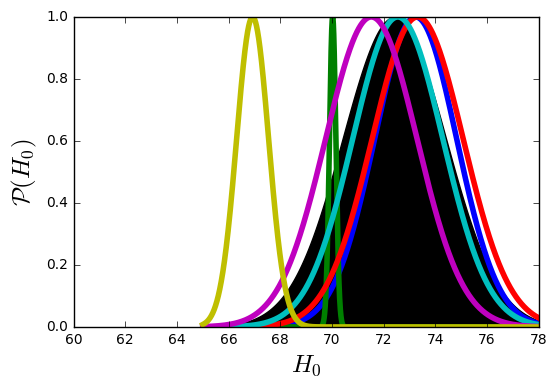

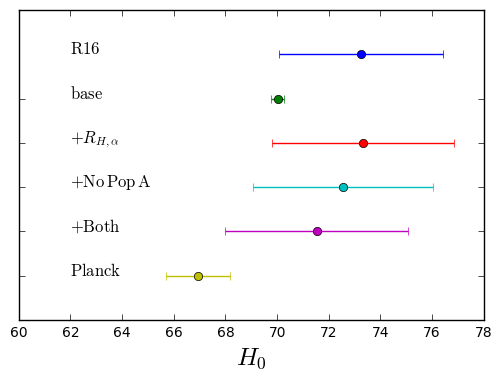

In [52]:
H_0 = []
bins = linspace(65,85, 100)
x = linspace(65,82, 10000)
fig, post_fig = subplots()
ylabel(r'$\mathcal{P}(H_0)$', fontsize = 18)
xlabel(r'$H_0$', fontsize= 18)
xlim(60,78)
ylim(0,1)
legend(frameon = False);

fig, box_fig = subplots()
xlim(60,78)
ylim(0,7)
xlabel(r'$H_0$', fontsize = 18)
yticks(arange(6), '')


for chain in [varyR_cut, varyR]:
    H_0 += list(choice(chain['H0'], size = 10000))
yvals, xvals = histogram(H_0, bins = bins, normed = True);
mu, sigma = norm.fit(H_0)
print sigma
H0 = norm(scale = sigma, loc = mu)
post_fig.fill_between(x, H0.pdf(x)/max(H0.pdf(x)), color = 'k', alpha = 1)
#box_fig.errorbar(mu, 1, xerr = 2*sigma, fmt = 'o')
#box_fig.text(80,1, )

H0R16 = norm(scale = 1.59, loc = 73.24)
post_fig.plot(x, H0R16.pdf(x)/max(H0R16.pdf(x)), label = r'${\rm R16}$', lw = 4)
box_fig.errorbar(73.24, 6, xerr = 2*1.59, fmt = 'o')
box_fig.text(62, 6, r'${\rm R}16$', fontsize = 12)
print 'R16', 73.24, 1.59
## Base case
xem, H_0, mu, sigma, maxval = like1d(base['H0'], base['weight'])
H0 = norm(scale = sigma, loc = mu)
post_fig.plot(x, H0.pdf(x)/maxval, label = r'${\rm base}$', lw = 4)
box_fig.errorbar(mu, 5, xerr = 2*sigma, fmt = 'o')
box_fig.text(62, 5, r'${\rm base}$', fontsize = 12)
print 'base', mu, sigma


## varyR
xem, H_0, mu, sigma, maxval = like1d(varyR['H0'], varyR['weight'])
H0 = norm(scale = sigma, loc = mu)
post_fig.plot(x, H0.pdf(x)/maxval, label = r'$+R_{H,\alpha}$', lw = 4)
box_fig.errorbar(mu, 4, xerr = 2*sigma, fmt = 'o')
box_fig.text(62, 4, r'$+R_{H,\alpha}$', fontsize = 12)

print 'Rtheta', mu, sigma

## Population cut cut

xem, H_0, mu, sigma, maxval = like1d(base_cut['H0'], base_cut['weight'])
H0 = norm(scale = sigma, loc = mu)
post_fig.plot(x, H0.pdf(x)/maxval, label = r'$ +{\rm No\, Pop\,A}$', lw = 4)
box_fig.errorbar(mu,3, xerr = 2*sigma, fmt = 'o')
box_fig.text(62, 3, r'$ +{\rm No\, Pop\,A}$', fontsize = 12)

print '2 pops', mu, sigma

xem, H_0, mu, sigma, maxval = like1d(varyR_cut['H0'], varyR_cut['weight'])
H0 = norm(scale = sigma, loc = mu)
post_fig.plot(x, H0.pdf(x)/maxval, label = r'$+{\rm both}$', lw = 4)
box_fig.errorbar(mu, 2, xerr = 2*sigma, fmt = 'o')
box_fig.text(62, 2, r'$ +{\rm Both}$', fontsize = 12)

print '2 pops', mu, sigma

## Planck
sigma = 0.62
mu = 66.93
H0planck = norm(scale = 0.62, loc = 66.93)
post_fig.plot(x, H0planck.pdf(x)/max(H0planck.pdf(x)), label = r'${\rm Planck}$', lw = 4)
box_fig.errorbar(mu, 1, xerr = 2*sigma, fmt = 'o')
box_fig.text(62, 1, r'$ {\rm Planck}$', fontsize = 12)




#post_fig.savefig('/Users/follin/Documents/projects/papers/local_hubble/FIGURES/H_0posterior.pdf')

std([73.29, 73.02, 72.54, 71.53])

In [53]:
from scipy.integrate import quad
def pvalue(chain):
    fitdata = [[d]*w for d,w in zip(chain['H0'], chain['weight'])]
    fitdata = [item for sublist in fitdata for item in sublist]

    x = norm(scale = 0.62, loc = 66.93).rvs(size = len(fitdata))
    pval = sum([(x>y) for x,y in zip(x, fitdata)])*1.0/len(fitdata)
    z = norm.ppf(pval)
    return pval, z
print 'base case', pvalue(base)
print '2 population cut', pvalue(base_cut)
print 'r free', pvalue(varyR)
print 'both', pvalue(varyR_cut)
print 'E(V-I) cut', pvalue(cutoff)

base case (0.0, -inf)
2 population cut

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


 (0.00090953540090532949, -3.1182845582228005)
r free (0.0003523390911413144, -3.3877525119504242)
both (0.0063897036051955621, -2.4898581953455943)
E(V-I) cut (0.0019947616653042547, -2.8789889336748651)


In [61]:
from sklearn.cluster import KMeans
ml = base.best_fit()
cepheids['Intrinsic'] = ((log10(cepheids.Period) - 1)* (ml['CP_l'] * (cepheids.Period < 10) 
                                                        + ml['CP_h'] * (cepheids.Period >= 10))
                         + ml['C0'] + (cepheids.Z-8.9)*ml['CZ']
                         )
cepheids['EVminusI'] = cepheids['VminusI'] - cepheids['Intrinsic']

classifier = KMeans(n_clusters = 2, n_init = 1000)
cephs = cepheids.copy()
features = ['VminusI', 'Period', 'Z']
for feature in features:
    if feature =='Period':
        cephs[feature] = log10(cepheids.Period)/(log10(cepheids.Period).max() - log10(cepheids.Period).min())
    else:
        cephs[feature] = cepheids[feature]/((cepheids[feature]).max() - (cepheids[feature]).min())
classifier.fit(cephs[features])
classification = classifier.predict(cephs[features])
cepheids['classes'] = classification

if mean(cepheids.loc[cepheids.classes == 1, 'Period']) > mean(cepheids.loc[cepheids.classes == 0, 'Period']):
    cepheids.classes = -cepheids.classes + 1
#cepheids = cepheids[cepheids.classes == 0]

KeyError: 'CP_l'

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


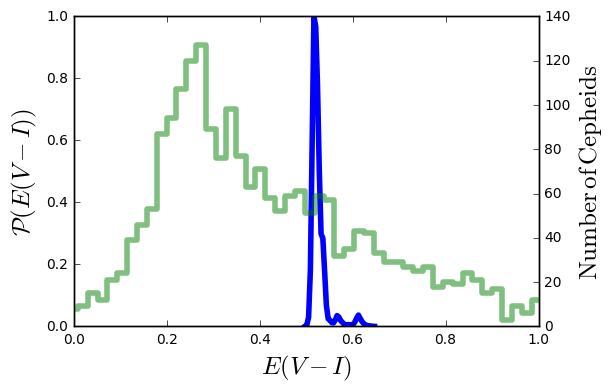

In [54]:

ax = subplot(111)
x = linspace(0.2,0.8, 10000)
xem, H, mu, sigma, maxval = like1d(cutoff['E_max'], cutoff['weight'])
Emax = norm(scale = sigma, loc = mu)
cutoff.like1d('E_max',nbins = 40, lw = 4)
#plot(x, Emax.pdf(x)/maxval, lw = 4)
#xlim(0.48,0.58);
ylabel(r'$\mathcal{P}(E(V-I))$', fontsize = 18)
xlabel(r'$E(V-I)$', fontsize= 18)
#
ax2 = twinx(ax)
ML = cutoff.best_fit()
cepheids['Extinction'] = cepheids.VminusI - ML['C0'] - (log10(cepheids.Period) - 1) * ML['CP'] - (cepheids.Z - 8.9)* ML['CZ']
bins = linspace(-0.5, 1.6, 100)
H, x = histogram(cepheids.Extinction, normed = False, bins = bins)
plot(x[:-1], H * 1.0, ls = 'steps', lw = 4, c='g', alpha = 0.5)
ylabel(r'${\rm Number\, of\, Cepheids}$',fontsize = 18)
xlim(0.0, 1);

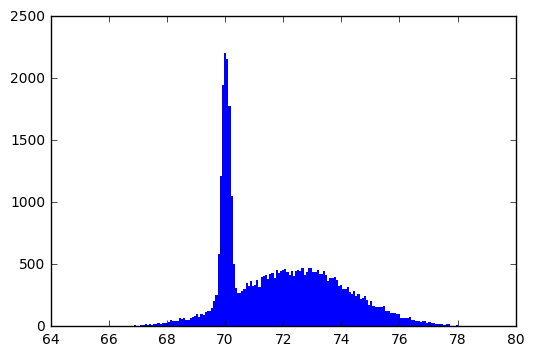

In [55]:
H_0 = []
for chain in [base, varyR, base_cut, varyR_cut]:
    H_0 += list(choice(chain['H0'], size = 10000))
hist(H_0, bins = 200, lw = 0);
    

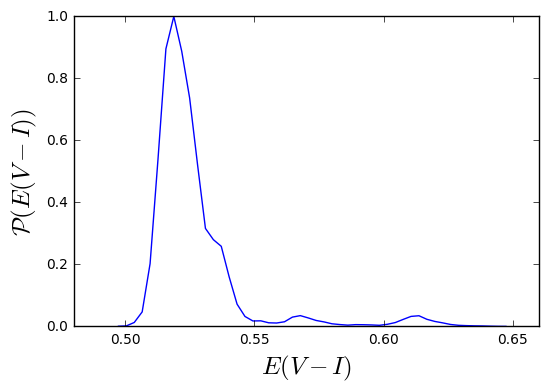

In [56]:
cutoff.like1d('E_max',nbins = 50)
ylabel(r'$\mathcal{P}(E(V-I))$', fontsize = 18)
xlabel(r'$E(V-I)$', fontsize= 18)

In [57]:
rprior = varyR.copy()
for param in rprior.params():
    if param[0:2] == 'R_':
        rprior['weight'] /= ((rprior[param])/0.1)**2

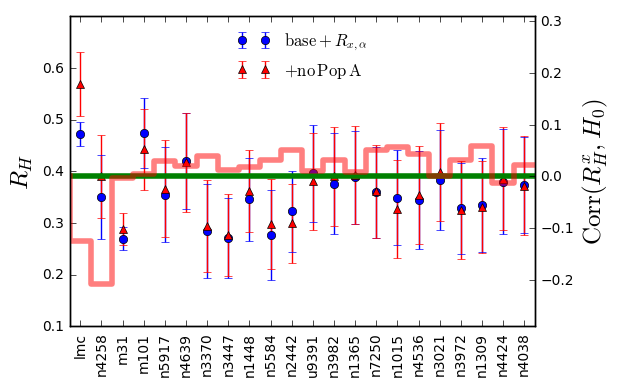

In [58]:
xvals = []
xerr = []
fields = []
for field in ['lmc','n4258', 'm31',
                  'm101', 'n5917', 'n4639', 
                  'n3370', 'n3447', 
                  'n1448', 'n5584', 'n2442', 
                  'u9391', 'n3982', 
                  'n1365', 'n7250', 'n1015', 
                  'n4536', 'n3021', 
                  'n3972', 'n1309', 'n4424', 
                  'n4038']:
    xvals += [varyR.mean('R_'+field) + 0.39]
    xerr += [varyR.std('R_'+field)]
    if field != 'galaxy':
        fields += [field]
    else:
        fields +=['MW']
ax1 = subplot(111)
xlim(-1, len(xvals))
errorbar(arange(len(xvals)), xvals, yerr = xerr, fmt = 'o', label =  r'${\rm base}+ R_{x,\alpha}$')

xvals = []
xerr = []
fields = []
for field in ['lmc','n4258', 'm31',
                  'm101', 'n5917', 'n4639', 
                  'n3370', 'n3447', 
                  'n1448', 'n5584', 'n2442', 
                  'u9391', 'n3982', 
                  'n1365', 'n7250', 'n1015', 
                  'n4536', 'n3021', 
                  'n3972', 'n1309', 'n4424', 
                  'n4038']:
    xvals += [varyR_cut.mean('R_'+field) + 0.39]
    xerr += [varyR_cut.std('R_'+field)]
    if field != 'galaxy':
        fields += [field]
    else:
        fields +=['MW']

errorbar(arange(len(xvals)), xvals, yerr = xerr, fmt = '^', color = 'r', label =  r'$+{\rm no\, Pop\, A}$')

#plot(arange(25), ones(25)*sum(array(xvals) * array(xerr)/sum(xerr)), label = r'${\rm mean\, }R_H$')  
plot(arange(-1, 25), ones(26) * 0.39, lw = 4)
legend( loc = 9, frameon = False)
xticks(arange(len(xvals)), fields, rotation='vertical');
#title(r'$R_H_{MW} \, {\rm free}$, \, $H_0 = 70.36 \pm 1.98$')
ylabel(r'$R_H$', fontsize = 18)
ylim(0.1, 0.7)
#fig.subplots_adjust(left = 0.2, bottom = 0.2, top = 0.95, right = 0.95)



ax = twinx(ax1)
fields = ['lmc','n4258', 'm31',
                  'm101', 'n5917', 'n4639', 
                  'n3370', 'n3447', 
                  'n1448', 'n5584', 'n2442', 
                  'u9391', 'n3982', 
                  'n1365', 'n7250', 'n1015', 
                  'n4536', 'n3021', 
                  'n3972', 'n1309', 'n4424', 
                  'n4038']
gridparams = ['H0'] + ['R_'+x for x in fields]
x = arange(len(gridparams))
corr = pd.DataFrame(varyR.corr(gridparams), index = gridparams, columns = gridparams)
corr.loc['H0','H0'] = 0

#plot(x-0.5,array(corr['H0']), ls = 'steps', lw = 4, c = 'b', alpha = 0.5)

corr = pd.DataFrame(varyR_cut.corr(gridparams), index = gridparams, columns = gridparams)
corr.loc['H0','H0'] = 0

plot(x-0.5,array(corr['H0']), ls = 'steps', lw = 4, c = 'r', alpha = 0.5)


#xlim(-0.5, len(gridparams)-0.5);
ylim(-0.3+.01, 0.3+.01)
#plot([-1, 30], [0,0], lw = 4)
#ylabel(r'$\frac{\langle H_0 R_{H}^x\rangle}{\sqrt{\langle H_0^2\rangle \langle (R_H^x)^2 \rangle}}$', fontsize = 18)
ylabel(r'${\rm Corr}(R_H^x, H_0)$', fontsize = 18)
xlim(-0.5, len(fields)-0.5);
#savefig('/Users/fo/papers/local_hubble/FIGURES/MW_free.png')
savefig('/Users/follin/Documents/projects/papers/local_hubble/FIGURES/R_H_by_field.pdf')

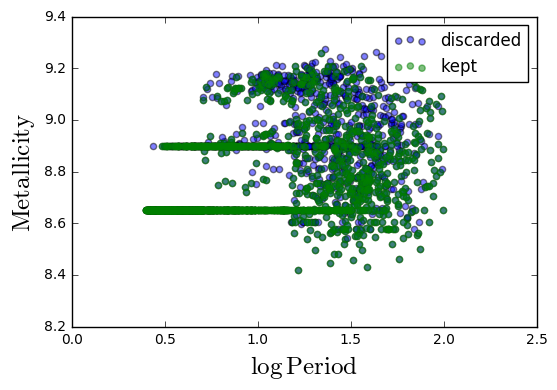

In [59]:
ml = cutoff.best_fit()
cepheids['EVminusI'] = cepheids['VminusI'] - ml['C0'] - ml['CP']*(log10(cepheids.Period)-1) - ml['CZ'] * (cepheids.Z - 8.9)
scatter(log10(cepheids['Period']),cepheids['Z'], alpha = 0.5,label = 'discarded')
scatter(
       log10(cepheids.loc[cepheids.EVminusI < ml['E_max'], 'Period']), 
       cepheids.loc[cepheids.EVminusI < ml['E_max'],'Z'], color = 'g', alpha = 0.5, label = 'kept')
ylabel(r'${\rm Metallicity}$', fontsize = 18)
xlabel(r'$\log {\rm \, Period}$', fontsize = 18)
legend()
#print cepheids.loc[cepheids.EVminusI < ml['E_max']]

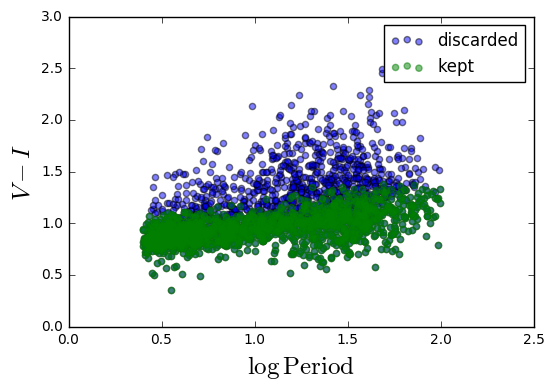

In [60]:
ml = cutoff.best_fit()
cepheids['EVminusI'] = cepheids['VminusI'] - ml['C0'] - ml['CP']*(log10(cepheids.Period)-1) - ml['CZ'] * (cepheids.Z - 8.9)
scatter(log10(cepheids['Period']),cepheids['VminusI'], alpha = 0.5, label = 'discarded')
scatter(
       log10(cepheids.loc[cepheids.EVminusI < ml['E_max'], 'Period']), 
       cepheids.loc[cepheids.EVminusI < ml['E_max'],'VminusI'], color = 'g', alpha = 0.5, label = 'kept')
ylabel(r'${V-I}$', fontsize = 18)
xlabel(r'$\log {\rm \, Period}$', fontsize = 18)
legend()
#print cepheids.loc[cepheids.EVminusI < ml['E_max']]

In [ ]:
cmap = get_cmap('bwr')

scatter(log10(cepheids.Period), cepheids.VminusI, color = cmap(cepheids.classes/1.01), alpha = 0.5, lw = 0)
xlabel(r'$\log_{10} P$', fontsize = 18)
ylabel(r'$(V-I)$', fontsize = 18)
savefig('/Users/follin/Documents/projects/papers/local_hubble/FIGURES/period_color.pdf')

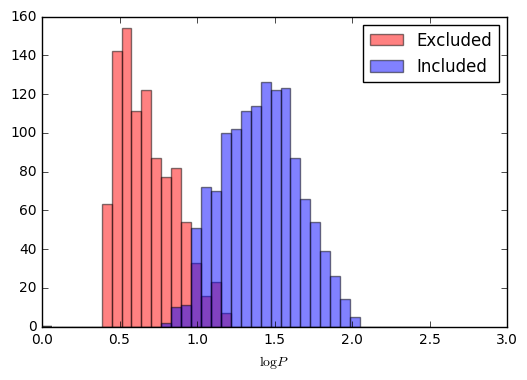

In [45]:
bins = linspace(0, 2.5, 40)
hist(log10(cepheids.loc[cepheids.classes == 1, 'Period']), bins = bins, color = cmap(0.99), alpha = 0.5,  label = 'Excluded');
hist(log10(cepheids.loc[cepheids.classes == 0, 'Period']), bins = bins, color = cmap(0.01), alpha = 0.5, label = 'Included');
xlabel(r'$\log P$')
legend()

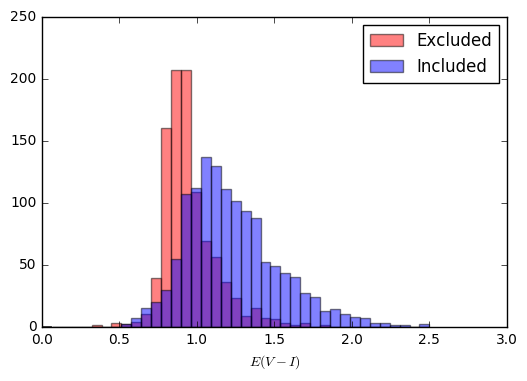

In [46]:
bins = linspace(0, 2.5, 40)
hist((cepheids.loc[cepheids.classes == 1, 'VminusI']), bins = bins, color = cmap(0.99), alpha = 0.5,  label = 'Excluded');
hist((cepheids.loc[cepheids.classes == 0, 'VminusI']), bins = bins, color = cmap(0.01), alpha = 0.5, label = 'Included');
xlabel(r'$E(V-I)$')
legend()

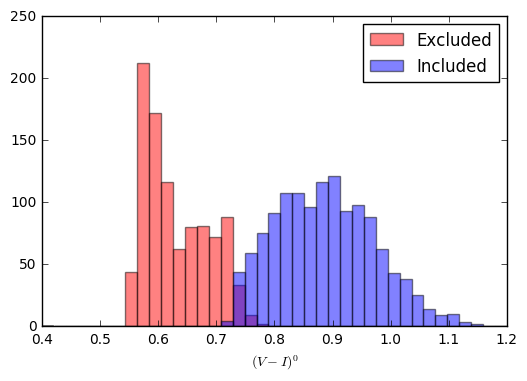

In [47]:
bins = linspace(0.4, 1.2, 40)
hist((cepheids.loc[cepheids.classes == 1, 'Intrinsic']), bins = bins, color = cmap(0.99), alpha = 0.5, label = 'Excluded');
hist((cepheids.loc[cepheids.classes == 0, 'Intrinsic']), bins = bins, color = cmap(0.01), alpha = 0.5, label = 'Included');
xlabel(r'$(V-I)^0$')
legend()

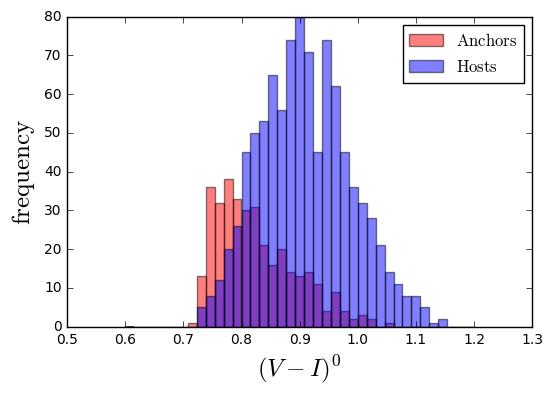

In [48]:
inccephs = cepheids[cepheids.classes == 0]
anchors = ['lmc', 'galaxy', 'n4258', 'm31']

anchorcephs = inccephs[inccephs.Field.isin(anchors)]
hostcephs = inccephs[~inccephs.Field.isin(anchors)]
bins = linspace(0.6,1.2, 40)
hist(anchorcephs['Intrinsic'].tolist(), bins = bins, color = 'r', alpha = 0.5, label = r'${\rm Anchors}$');
hist(hostcephs['Intrinsic'].tolist(), bins = bins, color = 'b', alpha = 0.5, label = r'${\rm Hosts}$');
legend();
xlabel(r'$(V-I)^0$', fontsize = 18)
ylabel(r'${\rm frequency}$', fontsize = 18)
savefig('/Users/follin/Documents/projects/papers/local_hubble/FIGURES/intrinsic_color_popA.pdf')

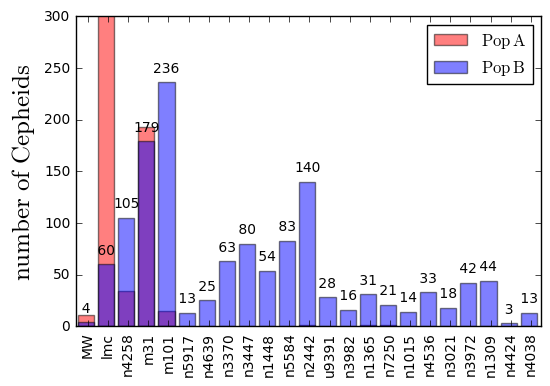

In [70]:
fields = ['galaxy','lmc','n4258', 'm31',
                  'm101', 'n5917', 'n4639', 
                  'n3370', 'n3447', 
                  'n1448', 'n5584', 'n2442', 
                  'u9391', 'n3982', 
                  'n1365', 'n7250', 'n1015', 
                  'n4536', 'n3021', 
                  'n3972', 'n1309', 'n4424', 
                  'n4038']

groups = cepheids.groupby(['Field', 'classes'])
yvals = groups.count()['m_H'][fields]
which_field = yvals.index.labels[0]
which_cluster = yvals.index.labels[1]
xvals = yvals[which_cluster ==1].index.levels[0].tolist()
xvals[0] = 'MW'
xlabels = xvals
which_field = yvals[which_cluster ==1].index.labels[0]
bar(arange(len(xlabels))[which_field], yvals[which_cluster == 1], color = 'r', alpha = 0.5,label = r'${\rm Pop\, A}$')
which_field = yvals[which_cluster ==0].index.labels[0]

bar(arange(len(xlabels))[which_field], yvals[which_cluster == 0], color = 'b', alpha = 0.5,label = r'${\rm Pop\, B}$')
for x,y in zip(arange(len(xlabels))[which_field], yvals[which_cluster == 0]):
    text(x-0.25,y+10,'%3.0f'%y)

ylim(0,300);
#gca().set_yscale("log", nonposy='clip')
#ylim(1e-1,1.0e3)
ylabel(r'${\rm number\,\, of\,\, Cepheids}$', fontsize = 18)
xticks(arange(len(xlabels)) + 0.5, xlabels, rotation = 'vertical');
#gca().yaxis.set_ticklabels(['','','$1$', '$10$', '$100$', '$1000$'])
xlim(-0.1, len(xlabels));
legend();
savefig('/Users/follin/Documents/projects/papers/local_hubble/FIGURES/popAB_distribution.pdf')

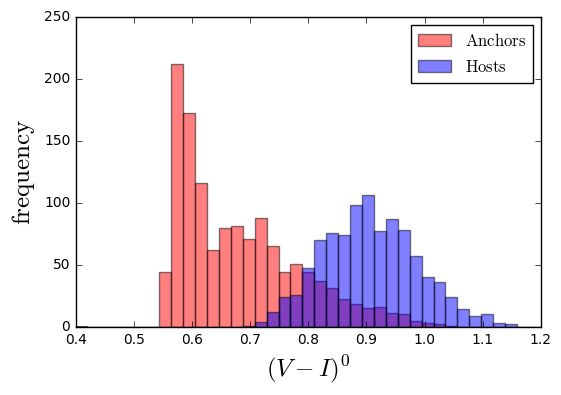

In [54]:
ml = base.best_fit()
cepheids['Intrinsic'] = ((log10(cepheids.Period) - 1)* (ml['CP_l'] * (cepheids.Period < 10) 
                                                        + ml['CP_h'] * (cepheids.Period >= 10))
                         + ml['C0'] + (cepheids.Z-8.9)*ml['CZ']
                         )
cepheids['EVminusI'] = cepheids['VminusI'] - cepheids['Intrinsic']
anchors = ['lmc', 'galaxy', 'n4258', 'm31']
anchorcephs = cepheids[cepheids.Field.isin(anchors)]
hostcephs = cepheids[~cepheids.Field.isin(anchors)]
bins = linspace(0.4,1.2, 40)
hist(anchorcephs['Intrinsic'].tolist(), bins = bins, color = 'r', alpha = 0.5, label = r'${\rm Anchors}$');
hist(hostcephs['Intrinsic'].tolist(), bins = bins, color = 'b', alpha = 0.5, label = r'${\rm Hosts}$');
legend();
xlabel(r'$(V-I)^0$', fontsize = 18)
ylabel(r'${\rm frequency}$', fontsize = 18)
savefig('/Users/follin/Documents/projects/papers/local_hubble/FIGURES/intrinsic_color_dist.pdf')

In [22]:
ml = base.best_fit()
print  ml['CP_h'], ml['CP_l'], ml['CZ'],ml['C0']

0.348257725297 0.19745580228 0.270232299209 0.743126002627


In [15]:
base.params()

{'C0',
 'CP_h',
 'CP_l',
 'CZ',
 'H0',
 'M_ceph',
 'M_sne',
 'a_B',
 'b',
 'b_l',
 'dz',
 'gamma',
 'mu_lmc',
 'mu_m101',
 'mu_m31',
 'mu_n1015',
 'mu_n1309',
 'mu_n1365',
 'mu_n1448',
 'mu_n2442',
 'mu_n3021',
 'mu_n3370',
 'mu_n3447',
 'mu_n3972',
 'mu_n3982',
 'mu_n4038',
 'mu_n4258',
 'mu_n4424',
 'mu_n4536',
 'mu_n4639',
 'mu_n5584',
 'mu_n5917',
 'mu_n7250',
 'mu_u9391'}

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture

In [21]:
cepheids['logP'] = log10(cepheids.Period)
features = cepheids[['logP', 'VminusI']]


(0, 11)

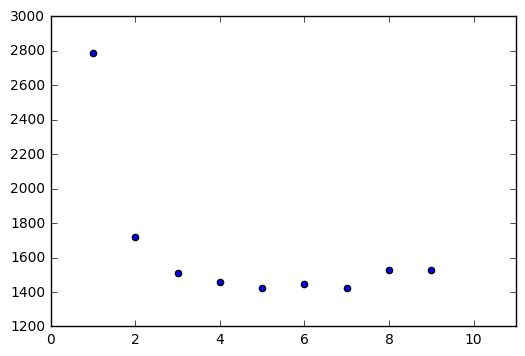

In [25]:
bic_array = []
for n_classes in arange(1,15):
    model = GaussianMixture(n_components = n_classes, max_iter = 100, n_init = 100, init_params= 'random')
    estimate = model.fit(features)
    bic_array += [model.bic(features)]
scatter(arange(1,15), bic_array)
xlim(0,16)

In [35]:
n_classes = 4
model = GaussianMixture(n_components = n_classes, max_iter = 1000, n_init = 1000, init_params= 'random')
cepheids['logP'] = log(cepheids.Period)
estimate = model.fit(features)
cmap = cm.get_cmap('Set2', n_classes)

(0, 2.5)

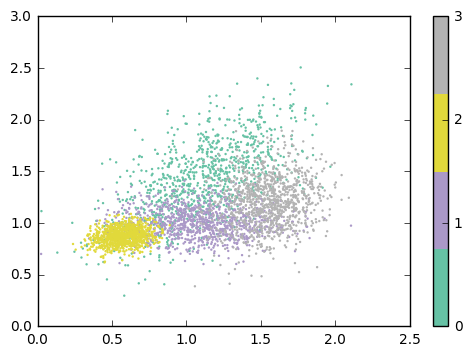

In [36]:
model.covariances_
from scipy.stats import multivariate_normal as norm
xvals = []
yvals = []
pop = []
pdf = norm(mean = model.means_[0], cov = model.covariances_[0,:,:])
vals = pdf.rvs(1000)
xvals += list(vals[:,0])
yvals += list(vals[:,1])
pop += [0]*1000


pdf = norm(mean = model.means_[1], cov = model.covariances_[1,:,:])
vals = pdf.rvs(1000)
xvals += list(vals[:,0])
yvals += list(vals[:,1])
pop += [1]*1000

pdf = norm(mean = model.means_[2], cov = model.covariances_[2,:,:])
vals = pdf.rvs(1000)
xvals += list(vals[:,0])
yvals += list(vals[:,1])
pop += [2]*1000

pdf = norm(mean = model.means_[3], cov = model.covariances_[3,:,:])
vals = pdf.rvs(1000)
xvals += list(vals[:,0])
yvals += list(vals[:,1])
pop += [3]*1000

scatter(xvals, yvals, cmap = cmap , c = pop, s = 3, lw = 0);
colorbar(ticks = arange(n_classes))
ylim(0,3)
xlim(0,2.5)

In [56]:
cepheids['Class'] = model.predict(features)
probs = model.predict_proba(features)

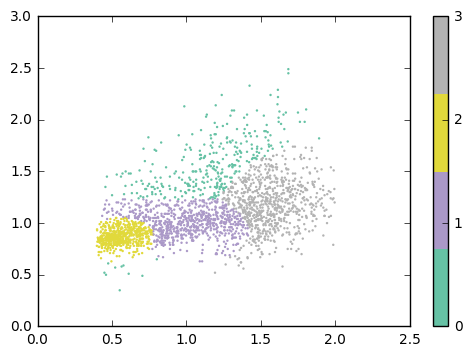

In [38]:
scatter(log10(cepheids.Period), cepheids.VminusI, s= 3, lw = 0, cmap = cmap, c = cepheids.Class)
colorbar(ticks = arange(n_classes))

In [53]:
rm 'gaussian_mixture_model'

In [54]:
gaussfile = open('gaussian_mixture_model', 'w')

pickle.dump(model, gaussfile)
gaussfile.close()

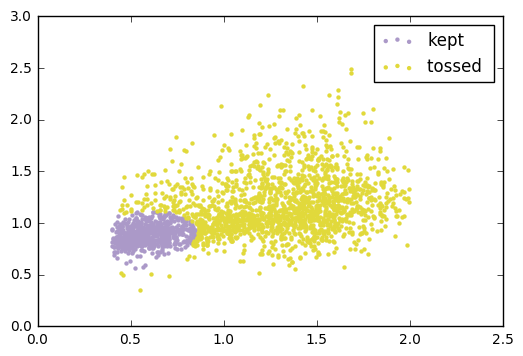

In [16]:
cepheids['Prob'] = (probs[:,1] > 0.1)
keep = cepheids.loc[cepheids.Prob == True,:]
toss = cepheids.loc[cepheids.Prob == False,:]
scatter(log10(keep.Period), keep.VminusI, c = cmap(1.0/4), s = 10, lw = 0, label ='kept')
scatter(log10(toss.Period), toss.VminusI, c = cmap(2.0/4), s = 10, lw = 0, label = 'tossed ')
legend()


In [17]:
classifications = cepheids.groupby('Class')

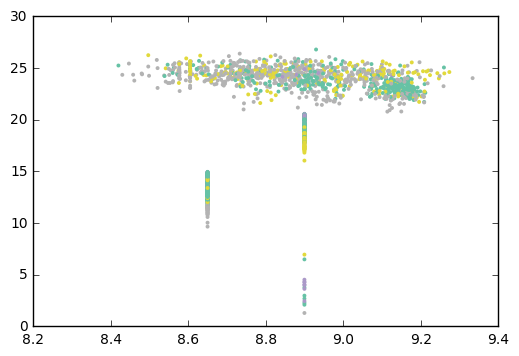

In [18]:
scatter(cepheids.Z, cepheids.m_H, c = cepheids.Class,cmap = cmap, s= 8, lw = 0)

In [19]:
classifications.mean()
classifications.count()

,Field,RA,DEC,ID,Period,VminusI,m_H,sigma_tot,Z,parallax,p_err,LK,err,logP,Prob
Class,,,,,,,,,,,,,,,
0,790,790,790,790,790,790,790,790,790,790,790,790,790,790,790
1,539,539,539,539,539,539,539,539,539,539,539,539,539,539,539
2,343,343,343,343,343,343,343,343,343,343,343,343,343,343,343
3,604,604,604,604,604,604,604,604,604,604,604,604,604,604,604


Field   Prob 
galaxy  False      8
        True       7
lmc     False    218
        True     557
n4258   False    131
        True       8
m31     False    297
        True      75
m101    False    238
        True      13
n5917   False     13
n4639   False     25
n3370   False     63
n3447   False     80
n1448   False     54
n5584   False     83
n2442   False    141
u9391   False     28
n3982   False     16
n1365   False     32
n7250   False     22
n1015   False     14
n4536   False     33
n3021   False     18
n3972   False     42
n1309   False     44
n4424   False      3
n4038   False     13
Name: m_H, dtype: int64


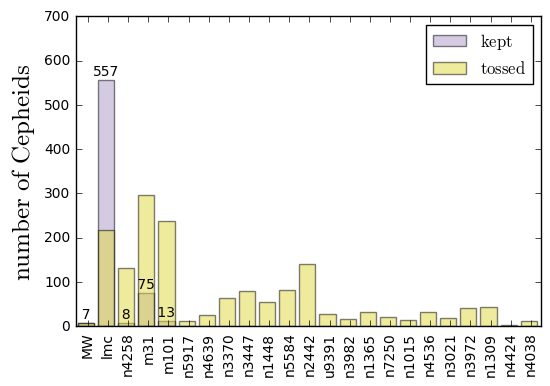

In [20]:
fields = ['galaxy','lmc','n4258', 'm31',
                  'm101', 'n5917', 'n4639', 
                  'n3370', 'n3447', 
                  'n1448', 'n5584', 'n2442', 
                  'u9391', 'n3982', 
                  'n1365', 'n7250', 'n1015', 
                  'n4536', 'n3021', 
                  'n3972', 'n1309', 'n4424', 
                  'n4038']

groups = cepheids.groupby(['Field', 'Prob'])
yvals = groups.count()['m_H'][fields]
print yvals
which_field = yvals.index.labels[0]
which_cluster = yvals.index.labels[1]
xvals = yvals[which_cluster ==1].index.levels[0].tolist()
xvals[0] = 'MW'
xlabels = xvals
# which_field = yvals[which_cluster ==0].index.labels[0]
# bar(arange(len(xlabels))[which_field], yvals[which_cluster == 0], color = cmap(0), alpha = 0.5,label = r'${\rm Pop\, 1}$')
which_field = yvals[which_cluster ==1].index.labels[0]
bar(arange(len(xlabels))[which_field], yvals[which_cluster == 1], color = cmap(1.0/4), alpha = 0.5,label = r'${\rm kept}$')
which_field = yvals[which_cluster ==0].index.labels[0]
bar(arange(len(xlabels))[which_field], yvals[which_cluster == 0],color = cmap(2.0/4),  alpha = 0.5,label = r'${\rm tossed}$')
# which_field = yvals[which_cluster ==3].index.labels[0]
# bar(arange(len(xlabels))[which_field], yvals[which_cluster == 3], color = cmap(3.0/4), alpha = 0.5,label = r'${\rm Pop\, 4}$')




for x,y in zip(arange(len(xlabels))[which_field], yvals[which_cluster == 1]):
     text(x-0.25,y+10,'%3.0f'%y)

ylim(0,700);
#gca().set_yscale("log", nonposy='clip')
#ylim(1e-1,1.0e3)
ylabel(r'${\rm number\,\, of\,\, Cepheids}$', fontsize = 18)
xticks(arange(len(xlabels)) + 0.5, xlabels, rotation = 'vertical');
#gca().yaxis.set_ticklabels(['','','$1$', '$10$', '$100$', '$1000$'])
xlim(-0.1, len(xlabels));
legend();
savefig('/Users/follin/Documents/projects/papers/local_hubble/FIGURES/popAB_distribution.pdf')

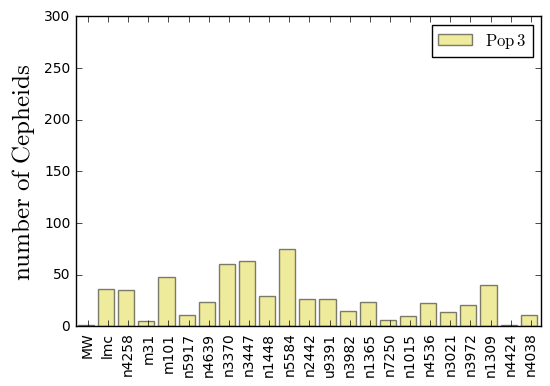

In [26]:

fields = ['galaxy','lmc','n4258', 'm31',
                  'm101', 'n5917', 'n4639', 
                  'n3370', 'n3447', 
                  'n1448', 'n5584', 'n2442', 
                  'u9391', 'n3982', 
                  'n1365', 'n7250', 'n1015', 
                  'n4536', 'n3021', 
                  'n3972', 'n1309', 'n4424', 
                  'n4038']

groups = cepheids.groupby(['Field', 'Class'])
yvals = groups.count()['m_H'][fields]
which_field = yvals.index.labels[0]
which_cluster = yvals.index.labels[1]
xvals = yvals[which_cluster ==1].index.levels[0].tolist()
xvals[0] = 'MW'
xlabels = xvals
# which_field = yvals[which_cluster ==0].index.labels[0]
# bar(arange(len(xlabels))[which_field], yvals[which_cluster == 0], color = cmap(0), alpha = 0.5,label = r'${\rm Pop\, 1}$')
# which_field = yvals[which_cluster ==1].index.labels[0]
# bar(arange(len(xlabels))[which_field], yvals[which_cluster == 1], color = cmap(1.0/4), alpha = 0.5,label = r'${\rm Pop\, 2}$')
which_field = yvals[which_cluster ==3].index.labels[0]
bar(arange(len(xlabels))[which_field], yvals[which_cluster == 3],color = cmap(2.0/4),  alpha = 0.5,label = r'${\rm Pop\, 3}$')
# which_field = yvals[which_cluster ==3].index.labels[0]
# bar(arange(len(xlabels))[which_field], yvals[which_cluster == 3], color = cmap(3.0/4), alpha = 0.5,label = r'${\rm Pop\, 4}$')




# for x,y in zip(arange(len(xlabels))[which_field], yvals[which_cluster == 4]):
#     text(x-0.25,y+10,'%3.0f'%y)

ylim(0,300);
#gca().set_yscale("log", nonposy='clip')
#ylim(1e-1,1.0e3)
ylabel(r'${\rm number\,\, of\,\, Cepheids}$', fontsize = 18)
xticks(arange(len(xlabels)) + 0.5, xlabels, rotation = 'vertical');
#gca().yaxis.set_ticklabels(['','','$1$', '$10$', '$100$', '$1000$'])
xlim(-0.1, len(xlabels));
legend();
savefig('/Users/follin/Documents/projects/papers/local_hubble/FIGURES/popAB_distribution.pdf')

In [27]:
groups.groups

{('galaxy',
  0): Int64Index([1487, 1488, 1489, 1490, 1491, 1499], dtype='int64'),
 ('galaxy',
  1): Int64Index([1492, 1493, 1494, 1495, 1496, 1497, 1498], dtype='int64'),
 ('galaxy', 2): Int64Index([1500], dtype='int64'),
 ('galaxy', 3): Int64Index([1486], dtype='int64'),
 ('lmc',
  0): Int64Index([1533, 1534, 1536, 1537, 1538, 1541, 1542, 1543, 1544, 1546,
             ...
             2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275],
            dtype='int64', length=248),
 ('lmc',
  1): Int64Index([1688, 1704, 1705, 1709, 1710, 1711, 1712, 1714, 1717, 1718,
             ...
             2246, 2250, 2252, 2253, 2254, 2255, 2258, 2260, 2261, 2263],
            dtype='int64', length=485),
 ('lmc', 2): Int64Index([1558, 1579, 1591, 1845, 2244, 2248], dtype='int64'),
 ('lmc',
  3): Int64Index([1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511,
             1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522,
             1523, 1524, 1525, 1526, 152

In [9]:

x = (cepheids.parallax/cepheids.p_err)

In [12]:
1/x[x < 10**10].mean()

0.07184627551552801

In [13]:
print 2

2
